In [3]:
import os
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
import torch
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


class feature_data_util():

    def getAllData(self,filepath=None):
        if filepath is None:
            filepath = "/content/sample_data/vp_clean_k_prev_busses.csv"
        df = pd.read_csv(filepath,low_memory=True)
        df.dropna(inplace=True)
        #y = df['Delay']

        feature_columns = list(df.columns)
        feature_columns.remove("delay")
        stop_names = list(df['stop_name'].unique())
        stop_name_map = {stop_names[i]:i for i in range(len(stop_names))}
        df['stop_name'] = df['stop_name'].map(stop_name_map)

        time_of_days = list(df['time_of_day'].unique())
        time_of_day_map = {time_of_days[i]:i for i in range(len(time_of_days))}
        df['time_of_day'] = df['time_of_day'].map(time_of_day_map)


        route_ids = list(df['route_id'].unique())
        route_ids_map = {route_ids[i]:i for i in range(len(route_ids))}
        df['route_id'] = df['route_id'].map(route_ids_map)

        #X = df[feature_columns][:k]
        X = df[feature_columns]

        def convert1(x):
            if x == 0:
                return 0
            return math.ceil(x / 60)

        df['delay'] = df['delay'].apply(convert1)

        def convert2(x):
            if x <= 10:
                return x
            if 10 < x <= 15:
                return 11
            if 15 < x <= 20:
                return 12
            if 20 < x <= 30:
                return 13
            return 14

        df['delay'] = df['delay'].apply(convert2)
        y = df['delay'].values

        #y = df['delay'][:k].values

        #one_hot_y = np.eye(num_classes)[y]
        return y,self.pre_process(X)


    def pre_process(self,data):
        mm = MinMaxScaler()
        scaled_data = mm.fit_transform(data)
        return scaled_data



class FeatureDataSet(Dataset):
    def __init__(self ):
        dataUtil=feature_data_util()

        self.lableData, self.trainData = dataUtil.getAllData()

        self.trainData = torch.from_numpy(self.trainData.astype(np.float32))
        self.lableData = torch.from_numpy(self.lableData.astype(np.float32))


    def __getitem__(self, index):
        train  = self.trainData[index]
        label  = self.lableData[index]

        return train, label

    def __len__(self):
        return len(self.trainData)

    def dataSet(self):
        return self.trainData,self.lableData


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc_layers = nn.ModuleList()
        self.fc_layers.extend([nn.Linear(10, 50), nn.ReLU()])
        self.fc_layers.extend([nn.Linear(50, 200), nn.ReLU()])
        self.fc_layers.extend([nn.Linear(200, 80),nn.ReLU()])
        self.fc_layers.extend([nn.Linear(80, 30),nn.ReLU()])
        self.fc_layers.extend([nn.Linear(30, 15)])

        self.encoder = nn.Sequential(*self.fc_layers)

    def forward(self, X):
        return self.encoder(X)




def do_train(path,model_name):
    if not os.path.exists(path):
        os.mkdir(path) 
    batch_size = 100
    learning_rate = 0.001
    epochs = 3000
    train_dataSet = FeatureDataSet()
    train_size = int(0.7 * len(train_dataSet))
    test_size = len(train_dataSet) - train_size
    train_dataSet, val_db = torch.utils.data.random_split(train_dataSet, [train_size, test_size],generator=torch.Generator().manual_seed(42))
    print('train:', len(train_dataSet), 'validation:', len(val_db))

    train_data_loader = DataLoader(train_dataSet,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   num_workers=2,
                                   drop_last=False)

    net = Net()

    criteon = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    best = 50000
    num_bad_epochs = 0
    for epoch in range(epochs):

        print("-----------------------------------------------------------------")
        print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
        net.train()
        running_loss = 0
        for i, (X_batch,Y_batch) in enumerate(tqdm(train_data_loader), 0):
            optimizer.zero_grad()
            pred = net(X_batch)
            # print(X_batch)
            # print(type(X_batch))
            # print(X_batch.shape)
            loss = criteon(pred, Y_batch.long())
            loss.backward()
            optimizer.step()

            running_loss = loss.item()

        print("Loss: {}".format(running_loss))
        if running_loss < best:
            print("############### Saving good model ###############################")
            final_model = net.state_dict()
            best = running_loss
            torch.save(final_model, './'+path+'/'+model_name+'.pth')
            #print(best)
            num_bad_epochs = 0
        else:
            num_bad_epochs = num_bad_epochs + 1


    print("Done")
    parameters = net.parameters()
    torch.save(final_model, './'+path+'/'+model_name+'.pth')
    print("best:" + str(best))


if __name__ == '__main__':
    path = "mode"
    model_name = "model2"
    do_train(path,model_name)

    # a ,b= feature_data_util().getAllData()
    # print(a.shape)
    # print(b.shape)




  0%|          | 0/3332 [00:00<?, ?it/s]

train: 333127 validation: 142770
-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.6329335570335388
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.6094828844070435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.567589282989502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5914270281791687
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5842352509498596
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5900182127952576
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5778485536575317
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 4


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5767093896865845
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 5


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5700786709785461
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 6


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5650954246520996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5566070675849915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5529953837394714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.565004289150238
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.55544513463974
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5690715909004211
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5582664012908936
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 4


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5919438600540161
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 5


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5858814716339111
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 6


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5467212796211243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5373641848564148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5282366275787354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5651881694793701
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5289915800094604
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5462996363639832
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5387822389602661
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 4


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5488681793212891
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 5


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5227491855621338
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.54050612449646
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5344409346580505
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5483052730560303
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5214462876319885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5391759276390076
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5857377052307129
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5292854905128479
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5581505298614502
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 4


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.534105658531189
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 5


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5248125791549683
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 6


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5196306705474854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5075423717498779
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5086897611618042
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5029579997062683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5212844014167786
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.514192521572113
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5080969333648682
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4868982434272766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4985949695110321
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4796115756034851
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.500133216381073
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.474107950925827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4876093566417694
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4907568693161011
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4855974614620209
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4869290590286255
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 4


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5174965858459473
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 5


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4969731867313385
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 6


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.47892284393310547
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 7


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4815971255302429
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 8


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4779406189918518
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 9


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4841477572917938
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 10


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.486800879240036
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 11


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5000961422920227
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 12


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4964892864227295
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 13


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48374465107917786
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 14


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4919234812259674
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 15


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4730440378189087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48527032136917114
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4753410220146179
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4761607348918915
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.46767520904541016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48365318775177
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.46192124485969543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4719964563846588
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.47904545068740845
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.46820923686027527
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48387208580970764
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 4


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4629448652267456
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 5


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.507157564163208
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 6


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.49119797348976135
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 7


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4821721613407135
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 8


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48287391662597656
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 9


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4824753403663635
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 10


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.49169906973838806
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 11


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.483960896730423
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 12


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.49100977182388306
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 13


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.49061939120292664
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 14


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4698726236820221
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 15


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48639896512031555
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 16


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.46276164054870605
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 17


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.45060136914253235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4999476969242096
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4915178716182709
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5146840214729309
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 3


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5023243427276611
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 4


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5284777283668518
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 5


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5137831568717957
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 6


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48355409502983093
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 7


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4694370925426483
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 8


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.48063167929649353
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 9


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.47589370608329773
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 10


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4981739819049835
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 11


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.49077048897743225
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 12


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4980689287185669
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 13


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4918403923511505
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 14


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4847448468208313
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 15


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4886740446090698
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 16


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.5271041989326477
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 17


  0%|          | 0/3332 [00:00<?, ?it/s]

Loss: 0.4860164225101471
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 18


 56%|█████▌    | 1862/3332 [00:12<00:10, 145.96it/s]

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


accurate: 0.7325826213896718
mse: 0.8017239882193458
r_squared: 0.3327941124655684


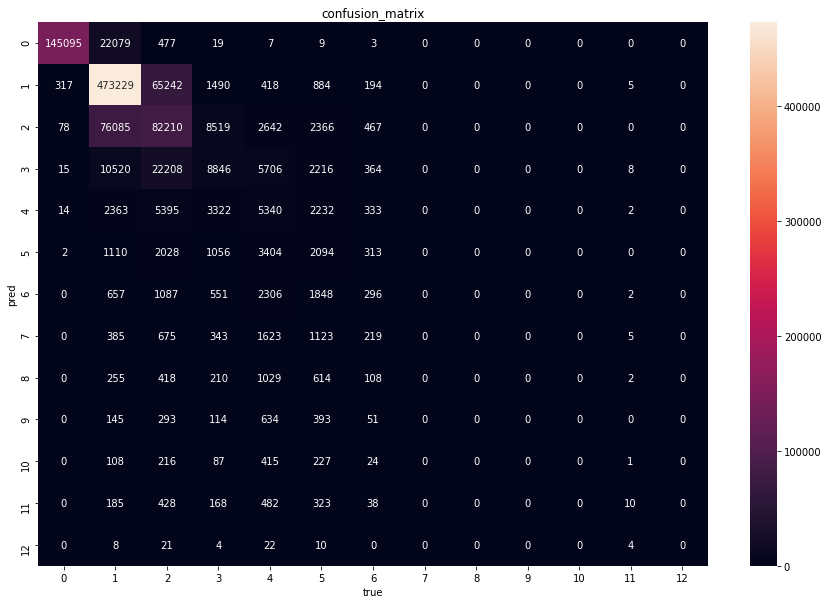

In [16]:

import pandas as pd
import torch
import math
import seaborn
import matplotlib.pyplot as plt
train_dataSet = FeatureDataSet()
train_size = int(0.7 * len(train_dataSet))
test_size = len(train_dataSet) - train_size
train_dataSet, val_db = torch.utils.data.random_split(train_dataSet, [train_size, test_size],generator=torch.Generator().manual_seed(42))
model = Net()
model.load_state_dict(torch.load('/content/mode/model2.pth'))

model.eval()

pred = model.forward(val_db.dataset.trainData)
pred = pred.argmax(dim=1)
y = val_db.dataset.lableData
correct = torch.eq(pred, y).float().sum().item()
num = y.size(0)
print("accurate:",correct/num)

pred =pred.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)

from sklearn.metrics import confusion_matrix
C = confusion_matrix(y, pred)
#df = pd.DataFrame(data=C,columns=['in time','1 mins','2 mins','3 mins'])
#df.set_index(['in time','1 mins','2 mins','3 mins'],inplace=True)
plt.figure(figsize=(15,10))

seaborn.heatmap(data=C,annot=True,fmt="d")
plt.title("confusion_matrix")
plt.xlabel("true")
plt.ylabel("pred")
plt.savefig("confusion_matrix.png")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse = mean_squared_error(pred,y)

print("mse:",mse)

r2 = math.sqrt(r2_score(pred,y))
#r_squared = math.sqrt()

print("r_squared:",r2)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


accurate: 0.7325826213896718


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


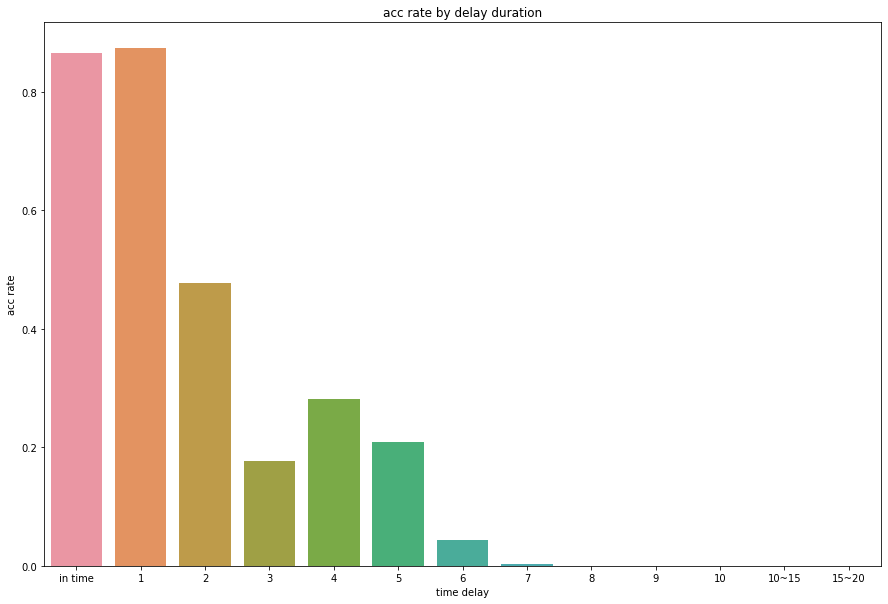

In [20]:
import pandas as pd
import torch
import seaborn
import matplotlib.pyplot as plt
train_dataSet = FeatureDataSet()
train_size = int(0.7 * len(train_dataSet))
test_size = len(train_dataSet) - train_size
train_dataSet, val_db = torch.utils.data.random_split(train_dataSet, [train_size, test_size],generator=torch.Generator().manual_seed(42))
model = Net()
model.load_state_dict(torch.load('/content/mode/model2.pth'))
model.eval()
pred = model.forward(val_db.dataset.trainData)

#pred = model(val_db.dataset.trainData)
# correct = torch.eq(pred, val_db).float().sum().item()
# num = X_batch.size(0)
# total_correct += correct
# total_num += X_batch.size(0)
#print(val_db.shape)

pred = pred.argmax(dim=1)
y = val_db.dataset.lableData
correct = torch.eq(pred, y).float().sum().item()
num = y.size(0)
print("accurate:",correct/num)

# seaborn.scatterplot(y,pred)
# plt.show()


pred =pred.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)
# pd.DataFrame({"real":y.tolist})

# print(pred.shape)
# print(y.shape)

data = np.append(y,pred,axis=1)
df = pd.DataFrame(data)

df.columns = ['y','pred']

df_num = df.groupby(by=['y']).count().reset_index(drop=True)
df_num.columns = ['y']
df_true = df[df['y'] == df['pred']]

df_true_num = df_true.groupby(by=['y']).count().reset_index(drop=True)
df_true_num.columns = ['true_num']

df_merge = df_num.join(df_true_num,how='left')
#a = pd.merge(df_num,df_true_num,how = 'left')

df_merge.fillna(0,inplace=True)

df_merge['rate'] = df_merge['true_num']/df_merge['y']

classes = ['in time','1','2','3','4','5','6','7','8','9','10','10~15','15~20','20~30','30+']
y_classes = pd.Series(classes)[df_merge.index.values]
plt.figure(figsize=(15,10))
seaborn.barplot(y_classes,df_merge['rate'])
plt.xlabel("time delay")
plt.ylabel("acc rate")
plt.title("acc rate by delay duration")
plt.show()
